In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import numpy as np
from PIL import Image

In [ ]:
# Step 1: Create directories
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/augmented_data', exist_ok=True)

# Extract zip files
zip_files = ['akeic.zip', 'df.zip', 'vasc.zip']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/content/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall('/content/data')

In [ ]:
# Step 2: Generate and save augmented images
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of augmented images to generate per original image
num_aug_per_image = 5

# Generate and save augmented images for each class
for class_name in os.listdir('/content/data'):
    class_path = os.path.join('/content/data', class_name)
    aug_class_path = os.path.join('/content/augmented_data', class_name)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in augmentation_datagen.flow(x, batch_size=1):
                    aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                    aug_img.save(os.path.join(aug_class_path, f'aug_{i}_{img_name}'))
                    i += 1
                    if i >= num_aug_per_image:
                        break

In [ ]:
# Step 3: Create combined data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create generators for both original and augmented data
train_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 648 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


In [ ]:
# Step 4: Load DenseNet169 Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Apply Attention Mechanism
x = base_model.output

# Attention mechanism on the feature map
attention = AdditiveAttention()([x, x])

# Apply Global Average Pooling
x = GlobalAveragePooling2D()(attention)

# Add Multiple Fully Connected Layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final Output Layer
predictions = Dense(3, activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Step 5: Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 6: Set up checkpoints
checkpoint = ModelCheckpoint('/content/densenet169_model_skin.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# History object for plotting
history = History()

In [ ]:
# Step 7: Train Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, history]
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3796 - loss: 1.4273
Epoch 1: val_loss improved from inf to 1.01073, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3788 - loss: 1.4261 - val_accuracy: 0.4403 - val_loss: 1.0107
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4271 - loss: 1.2125
Epoch 2: val_loss improved from 1.01073 to 0.88034, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.4276 - loss: 1.2115 - val_accuracy: 0.6352 - val_loss: 0.8803
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4687 - loss: 1.0614
Epoch 3: val_loss improved from 0.88034 to 0.78334, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.4691 - loss: 1.0609 - val_accuracy: 0.7610 - val_loss: 0.7833
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5418 - loss: 0.9991
Epoch 4: val_loss improved from 0.78334 to 0.72457, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.5403 - loss: 0.9994 - val_accuracy: 0.7862 - val_loss: 0.7246
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5862 - loss: 0.9168
Epoch 5: val_loss improved from 0.72457 to 0.66508, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.5856 - loss: 0.9168 - val_accuracy: 0.8050 - val_loss: 0.6651
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5977 - loss: 0.9064
Epoch 6: val_loss improved from 0.66508 to 0.58974, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.5976 - loss: 0.9056 - val_accuracy: 0.8553 - val_loss: 0.5897
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6525 - loss: 0.7795
Epoch 7: val_loss improved from 0.58974 to 0.51485, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.6530 - loss: 0.7792 - val_accuracy: 0.8679 - val_loss: 0.5149
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6605 - loss: 0.7828
Epoch 8: val_loss improved from 0.51485 to 0.45109, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.6610 - loss: 0.7820 - val_accuracy: 0.9057 - val_loss: 0.4511
Epoch 9/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6995 - loss: 0.7447
Epoch 9: val_loss improved from 0.45109 to 0.41027, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.7012 - loss: 0.7398 - val_accuracy: 0.9182 - val_loss: 0.4103
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7562 - loss: 0.6250
Epoch 10: val_loss improved from 0.41027 to 0.36840, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.7562 - loss: 0.6255 - val_accuracy: 0.9308 - val_loss: 0.3684
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7438 - loss: 0.6225
Epoch 11: val_loss improved from 0.36840 to 0.34064, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.7454 - loss: 0.6199 - val_accuracy: 0.9308 - val_loss: 0.3406
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7691 - loss: 0.5430
Epoch 12: val_loss improved from 0.34064 to 0.31138, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.7694 - loss: 0.5428 - val_accuracy: 0.9245 - val_loss: 0.3114
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8098 - loss: 0.5296
Epoch 13: val_loss improved from 0.31138 to 0.29589, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.8091 - loss: 0.5302 - val_accuracy: 0.9245 - val_loss: 0.2959
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8357 - loss: 0.4264
Epoch 14: val_loss improved from 0.29589 to 0.26339, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.8353 - loss: 0.4278 - val_accuracy: 0.9434 - val_loss: 0.2634
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8457 - loss: 0.4618
Epoch 15: val_loss improved from 0.26339 to 0.25539, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.8453 - loss: 0.4621 - val_accuracy: 0.9434 - val_loss: 0.2554
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8372 - loss: 0.4571
Epoch 16: val_loss improved from 0.25539 to 0.24288, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.8372 - loss: 0.4561 - val_accuracy: 0.9434 - val_loss: 0.2429
Epoch 17/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8462 - loss: 0.4240
Epoch 17: val_loss improved from 0.24288 to 0.22691, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.8462 - loss: 0.4244 - val_accuracy: 0.9434 - val_loss: 0.2269
Epoch 18/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8201 - loss: 0.4384
Epoch 18: val_loss did not improve from 0.22691
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.8209 - loss: 0.4372 - val_accuracy: 0.9434 - val_loss: 0.2279
Epoch 19/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8462 - loss: 0.4099
Epoch 19: val_loss improved from 0.22691 to 0.21142, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.8463 - loss: 0.4088 - val_accuracy: 0.9434 - val_loss: 0.2114
Epoch 20/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8685 - loss: 0.3855
Epoch 20: val_loss improved from 0.21142 to 0.19817, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8681 - loss: 0.3846 - val_accuracy: 0.9434 - val_loss: 0.1982
Epoch 21/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8857 - loss: 0.3078
Epoch 21: val_loss did not improve from 0.19817
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.8848 - loss: 0.3093 - val_accuracy: 0.9245 - val_loss: 0.2009
Epoch 22/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8596 - loss: 0.3674
Epoch 22: val_loss improved from 0.19817 to 0.19530, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.8600 - loss: 0.3662 - val_accuracy: 0.9434 - val_loss: 0.1953
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8907 - loss: 0.3093
Epoch 23: val_loss did not improve from 0.19530
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8898 - loss: 0.3103 - val_accuracy: 0.9371 - val_loss: 0.1978
Epoch 24/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8991 - loss: 0.3037
Epoch 24: val_loss improved from 0.19530 to 0.19443, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8987 - loss: 0.3040 - val_accuracy: 0.9308 - val_loss: 0.1944
Epoch 25/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8715 - loss: 0.3297
Epoch 25: val_loss improved from 0.19443 to 0.17720, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8723 - loss: 0.3280 - val_accuracy: 0.9434 - val_loss: 0.1772
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8882 - loss: 0.2877
Epoch 26: val_loss did not improve from 0.17720
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.8886 - loss: 0.2875 - val_accuracy: 0.9182 - val_loss: 0.1966
Epoch 27/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8984 - loss: 0.2947
Epoch 27: val_loss improved from 0.17720 to 0.16315, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.8985 - loss: 0.2939 - val_accuracy: 0.9434 - val_loss: 0.1631
Epoch 28/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9315 - loss: 0.2406
Epoch 28: val_loss did not improve from 0.16315
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9310 - loss: 0.2415 - val_accuracy: 0.9308 - val_loss: 0.1794
Epoch 29/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9196 - loss: 0.2429
Epoch 29: val_loss did not improve from 0.16315
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9198 - loss: 0.2428 - val_accuracy: 0.9308 - val_loss: 0.1680
Epoch 30/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9260 - loss: 0.2022
Epoch 30: val_loss improved from 0.16315 to 0.15770, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.9260 - loss: 0.2029 - val_accuracy: 0.9371 - val_loss: 0.1577
Epoch 31/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9279 - loss: 0.2116
Epoch 31: val_loss improved from 0.15770 to 0.15258, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9279 - loss: 0.2114 - val_accuracy: 0.9497 - val_loss: 0.1526
Epoch 32/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9207 - loss: 0.2617
Epoch 32: val_loss did not improve from 0.15258
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9210 - loss: 0.2600 - val_accuracy: 0.9434 - val_loss: 0.1601
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9486 - loss: 0.1554
Epoch 33: val_loss improved from 0.15258 to 0.15186, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9480 - loss: 0.1569 - val_accuracy: 0.9497 - val_loss: 0.1519
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9335 - loss: 0.1717
Epoch 34: val_loss did not improve from 0.15186
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9332 - loss: 0.1732 - val_accuracy: 0.9371 - val_loss: 0.1639
Epoch 35/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9492 - loss: 0.1604
Epoch 35: val_loss improved from 0.15186 to 0.14437, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.9488 - loss: 0.1612 - val_accuracy: 0.9497 - val_loss: 0.1444
Epoch 36/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9438 - loss: 0.1611
Epoch 36: val_loss did not improve from 0.14437
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9436 - loss: 0.1617 - val_accuracy: 0.9308 - val_loss: 0.1746
Epoch 37/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9406 - loss: 0.1694
Epoch 37: val_loss did not improve from 0.14437
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9403 - loss: 0.1695 - val_accuracy: 0.9497 - val_loss: 0.1474
Epoch 38/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9448 - loss: 0.1655
Epoch 38: val_loss improved from 0.14437 to 0.13822, saving model to /content/densenet169_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.9447 - loss: 0.1651 - val_accuracy: 0.9497 - val_loss: 0.1382
Epoch 39/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9420 - loss: 0.1566
Epoch 39: val_loss did not improve from 0.13822
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.9422 - loss: 0.1569 - val_accuracy: 0.9371 - val_loss: 0.1550
Epoch 40/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9466 - loss: 0.1588
Epoch 40: val_loss did not improve from 0.13822
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9465 - loss: 0.1589 - val_accuracy: 0.9497 - val_loss: 0.1435
Epoch 41/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9570 - loss: 0.1232
Epoch 41: val_loss did not improve from 0.13822
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9565 - loss: 0.1245 - val_accuracy: 0.9371 - val_loss: 0.1542
Epoch 42/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9547 - loss: 0.1336
Epoch 42: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.9684 - loss: 0.1152 - val_accuracy: 0.9434 - val_loss: 0.1331
Epoch 46/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9546 - loss: 0.1179
Epoch 46: val_loss did not improve from 0.13311
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9544 - loss: 0.1181 - val_accuracy: 0.9371 - val_loss: 0.1707
Epoch 47/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9729 - loss: 0.0719
Epoch 47: val_loss did not improve from 0.13311
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9726 - loss: 0.0730 - val_accuracy: 0.9497 - val_loss: 0.1385
Epoch 48/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9595 - loss: 0.1191
Epoch 48: val_loss did not improve from 0.13311
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.9594 - loss: 0.1193 - val_accuracy: 0.9371 - val_loss: 0.1693
Epoch 49/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9619 - loss: 0.1106
Epoch 49: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9553 - loss: 0.1083 - val_accuracy: 0.9560 - val_loss: 0.1321
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9726 - loss: 0.0897
Epoch 51: val_loss did not improve from 0.13208
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9724 - loss: 0.0898 - val_accuracy: 0.9434 - val_loss: 0.1630
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9756 - loss: 0.0924
Epoch 52: val_loss did not improve from 0.13208
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9756 - loss: 0.0920 - val_accuracy: 0.9434 - val_loss: 0.1481
Epoch 53/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9645 - loss: 0.0868
Epoch 53: val_loss did not improve from 0.13208
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9646 - loss: 0.0869 - val_accuracy: 0.9434 - val_loss: 0.1644
Epoch 54/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9735 - loss: 0.0813
Epoch 54: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9924 - loss: 0.0177 - val_accuracy: 0.9497 - val_loss: 0.1242
Epoch 99/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9989 - loss: 0.0124
Epoch 99: val_loss did not improve from 0.12425
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.9987 - loss: 0.0125 - val_accuracy: 0.9560 - val_loss: 0.1384
Epoch 100/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 100: val_loss did not improve from 0.12425
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9560 - val_loss: 0.1561


In [ ]:
# Step 8: Save the final model
model.save('/content/densenet169_model_skin_final.h5')
print("Final model saved successfully.")

Final model saved successfully.


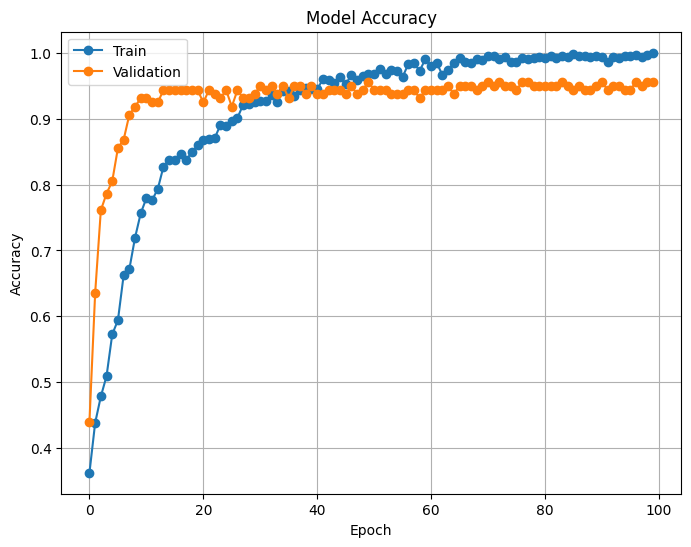

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

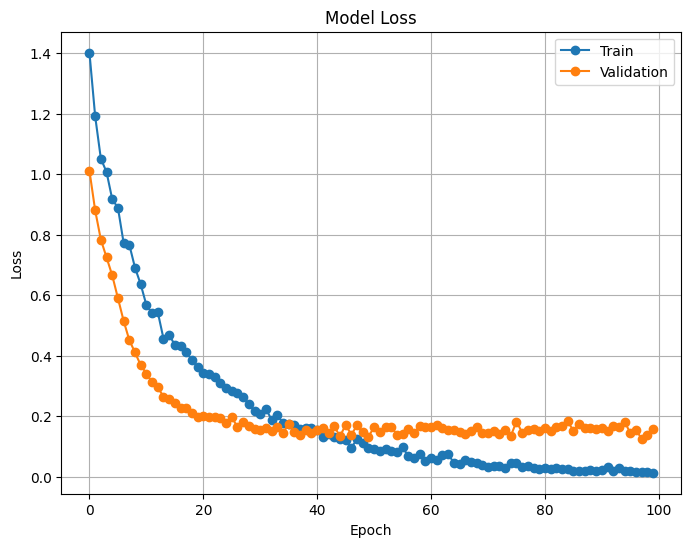

In [ ]:
# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()


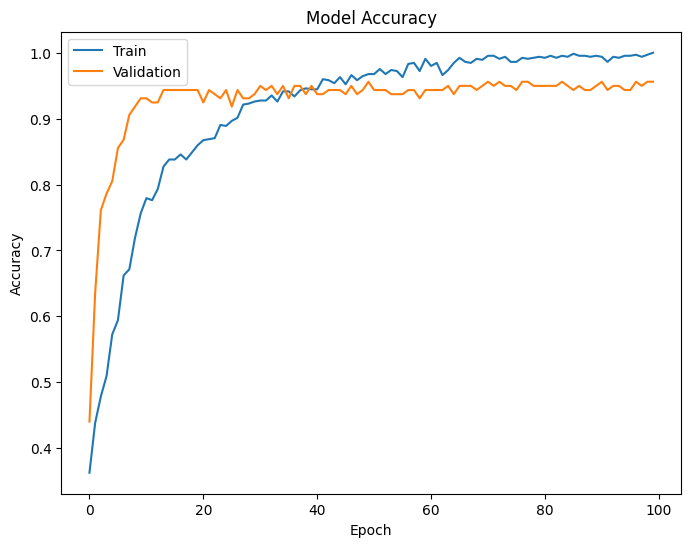

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(False)
plt.show()

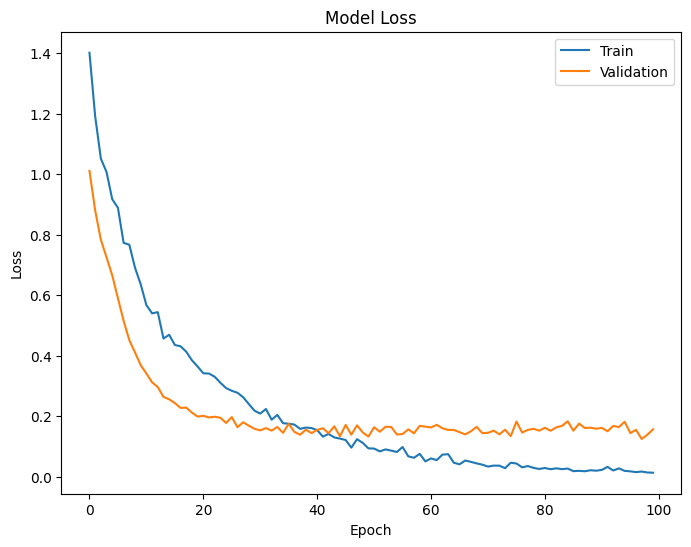

In [ ]:
# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(False)
plt.show()